In [23]:
from datetime import datetime as dt

import pandas as pd
import numpy as np

from preprocessing import Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample



from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay

# Preprocessing

In [24]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [25]:
train.shape

(165034, 11)

In [26]:
X = train.drop(columns='Exited')
y = train.Exited

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.15)

In [28]:
prepro = Preprocessing()

In [29]:
X_train_scld = prepro.fit_transform(X_train).astype(float)
X_test_scld = prepro.transform(X_test).astype(float)

In [30]:
X_train_balanced, y_train_balanced = resample(X_train_scld[y_train == 1], y_train[y_train == 1], n_samples=np.sum(y_train == 0), replace=True, random_state=42)

In [31]:
X_train_balanced = np.concatenate((X_train_scld[y_train == 0], X_train_balanced))
y_train_balanced = np.concatenate((y_train[y_train == 0], y_train_balanced))

# Model

In [32]:
results = {
    'models' : [
        ('rf', RandomForestClassifier()),
        ('histgradboost', HistGradientBoostingClassifier()),
        ('gradboost', GradientBoostingClassifier()),
        ('adaboost', AdaBoostClassifier()),
        ('Xgb', XGBClassifier())
        ],
    'mean_score' :[],
    'std_dev_score' :[] 
}
for _, model in results.get('models') :
    scores = cross_val_score(model,
                            X_train_scld,
                            y_train,
                            scoring = 'roc_auc',
                            cv = 4,
                            n_jobs = -1)
    results['mean_score'].append(scores.mean())
    results['std_dev_score'].append(scores.std())
    
    name = type(model).__name__ 
    print(f'{name} - Roc AUC score: {scores.mean():.4f} ± {scores.std():.4f}')

RandomForestClassifier - Roc AUC score: 0.8737 ± 0.0018
HistGradientBoostingClassifier - Roc AUC score: 0.8886 ± 0.0015
GradientBoostingClassifier - Roc AUC score: 0.8881 ± 0.0016
AdaBoostClassifier - Roc AUC score: 0.8801 ± 0.0017
XGBClassifier - Roc AUC score: 0.8854 ± 0.0018


In [33]:
voting = VotingClassifier(
    estimators=results.get('models'),
    voting='soft',
    weights=results.get('mean_score')
)

In [34]:
voting.fit(X_train_scld,y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('histgradboost',
                              HistGradientBoostingClassifier()),
                             ('gradboost', GradientBoostingClassifier()),
                             ('adaboost', AdaBoostClassifier()),
                             ('Xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_ro...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft',
                 weights=[0.8737405111835885, 0.8886305472484926,
                          0.8881359152181719, 0.8801130698094033,
                          0.8853705963995327])

In [35]:
pred = voting.predict(X_test_scld)
pred_proba = voting.predict_proba(X_test_scld)[:,1]

# Score

In [36]:
RocScore  = roc_auc_score(y_test, pred_proba)
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.889617


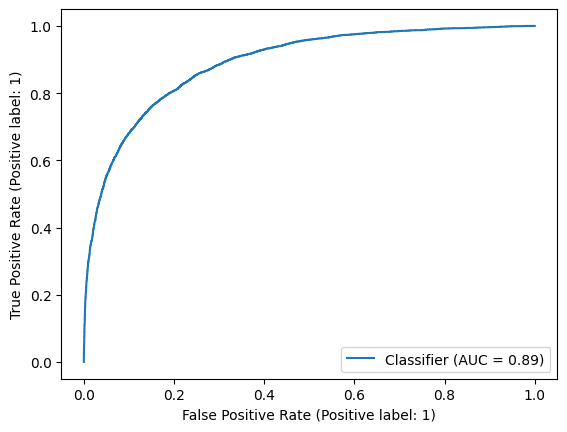

In [37]:
RocCurveDisplay.from_predictions(y_test,pred_proba)

In [38]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     19518
           1       0.75      0.55      0.63      5238

    accuracy                           0.87     24756
   macro avg       0.82      0.75      0.78     24756
weighted avg       0.86      0.87      0.86     24756



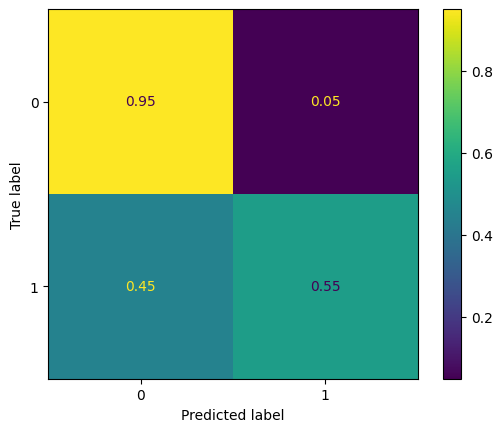

In [39]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred, normalize='true')).plot()

# Submission

In [40]:
X_val_scld = prepro.transform(test)

In [41]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [43]:
submission.loc[:,'Exited'] = voting.predict_proba(X_val_scld.values)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.11/site-packages/sklearn/base.py:4

In [44]:
submission

,Exited
id,
165034,0.130886
165035,0.775047
165036,0.114236
165037,0.280280
165038,0.336670
...,...
275052,0.136823
275053,0.181387
275054,0.109932


In [45]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [46]:
#submission.to_csv(f"submission/{name}.csv")